In [10]:
import os
import shutil

In [11]:
base_image_path = 'brisc2025/segmentation_task/train/images'
nameImage = 'Sorted_Images'
folders_set = set()

bip = os.listdir(base_image_path)

for b in bip:
    remove_jpg =  b.replace(".jpg", "")
    split_b = remove_jpg.split('_')
    folder = '_'.join(split_b[3:6])
    folders_set.add(folder)
    
    if not os.path.isdir(nameImage):
        os.mkdir(nameImage)
        print(f"Folder '{nameImage}' created.") 

for folder in folders_set:
        sub = os.path.join(nameImage, folder)
        os.makedirs(sub, exist_ok=True)
        print(f"Folder '{sub}' created successfully.") 
    

In [12]:
base_mask_path = 'brisc2025/segmentation_task/train/masks'
nameMask = 'Sorted_Masks'
folders_set = set()

bip = os.listdir(base_mask_path)

for b in bip:
    remove_jpg =  b.replace(".jpg", "")
    split_b = remove_jpg.split('_')
    folder = '_'.join(split_b[3:6])
    folders_set.add(folder)
    print(folders_set)
    if not os.path.isdir(nameMask):
        os.mkdir(nameMask)
        print(f"Folder '{nameMask}' created.") 

for folder in folders_set:
        sub = os.path.join(nameMask, folder)
        os.makedirs(sub, exist_ok=True)
        print(f"Folder '{sub}' created successfully.") 

In [13]:
source_d = 'brisc2025/segmentation_task/train/masks' #change for basedir
dest_d = 'Sorted_Masks/pi_sa_t1' #change accordingly for subdir

for images in os.listdir(source_d):
    s_path = os.path.join(source_d, images)
    d_path = os.path.join(dest_d, images)

    if os.path.isfile(s_path):
        if images.__contains__('pi_sa_t1'): #chnage accordingly for subdir
            shutil.move(s_path, d_path)
            print(f"Moved '{images}' to '{d_path}'")

In [14]:
sort_images = 'Sorted_Images'
sort_masks = 'Sorted_Masks'


for dirpath, dirname, files in os.walk(sort_images):
    for f1 in files:
        sort_image_path = os.path.join(dirpath, f1) 
        
for dirpath, dirname, files in os.walk(sort_masks):
    for f2 in files:
        sort_mask_path = os.path.join(dirpath, f2)
        split_smp = sort_mask_path.split('_')
        code_numberM = split_smp[2]
    
    for f in files:
        if f.__contains__(code_numberM):
                print(sort_mask_path)
                print(code_numberM)

Sorted_Masks/.DS_Store
Store
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Masks/gl_co_t1/brisc2025_train_00479_gl_co_t1.jpg
co
Sorted_Mask

In [15]:
numkeys = []

for dirpath, dirname, files in os.walk(sort_images):
    for f in files:
        jpg = f.replace(".jpg", "")
        split = jpg.split('_')
        numkey = split[2:6]
        joined_numkey = '_'.join(numkey)
        numkeys.append(joined_numkey) 

In [16]:
#d_(x) <- dierectory 
#dn_(x) <- directory name
#f_(x) <- files in direcotry 

batch_paths = []

for (d_m, dn_ms, f_m), (d_i, dn_is, f_i) in zip(os.walk(sort_masks), os.walk(sort_images)):
        for f1, f2 in zip(f_i, f_m):
               full_path_i = os.path.join(d_i, f1)
               full_path_m = os.path.join(d_m, f2)
               
               for n in numkeys:
                       if full_path_i.__contains__(n) and full_path_m.__contains__(n):
                               batch_paths.append((full_path_i, full_path_m))

In [17]:
#addition of labels because i did not have labels and i need for for image and mask
# image label = classifcation 
# mask label = segemtation

#label dict 

# there are 3 tyoes of tumors and for each type there are 3 subtypes (this is why i have nine labels)
tumor_to_label = {
    "gl_ax_t1": 0, 
    "gl_co_t1": 1,
    "gl_sa_t1": 2,
    "me_ax_t1": 3,
    "me_co_t1": 4,
    "me_sa_t1": 5,
    "pi_ax_t1": 6,
    "pi_co_t1": 7,
    "pi_sa_t1": 8,
}

labels = []

#loop for finding images for labelling purposes
for img_path, mask_path in batch_paths:
    folder = os.path.basename(os.path.dirname(img_path))
    labels.append(tumor_to_label[folder])


In [18]:
import torch
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [19]:
print(torch.__version__)

2.8.0


In [20]:

#IMG and Mask Transformations (resize 224, 224), tensor output
transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#storage 
Tensor_Batch = []

for img_path, mask_path in batch_paths:
    
    image = Image.open(img_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    tensorI = transform_img(image)
    tensorM = transform_mask(mask)
    Tensor_Batch.append((tensorI, tensorM))

print("size of dataset after processing:", len(Tensor_Batch))

size of dataset after processing: 3933


In [21]:

class ImageMask(Dataset):

    def __init__(self, img_mask_pairs, labels, img_transform=None, mask_transform=None):
        #updated to include location for pairs, labels, and transforms
        self.img_mask_pairs = img_mask_pairs
        self.labels = labels
        self.img_transform = img_transform
        self.mask_transform = mask_transform
    
    def __len__(self):
        #returns len of images 
        return len(self.img_mask_pairs)
    
    def __getitem__(self, idx):
         #finds images and masks
         img_path, mask_path = self.img_mask_pairs[idx]
         
         #opens images and masks
         image = Image.open(img_path).convert("L")
         mask = Image.open(mask_path).convert("L")

         #applying the tranformations
         if self.img_transform:
              image = self.img_transform(image)
         if self.mask_transform:
             mask = self.mask_transform(mask)

         #lable declaration
         label = torch.tensor(self.labels[idx], dtype=torch.long)

         return image, mask, label

In [22]:
custom_ds = ImageMask(img_mask_pairs=batch_paths,labels=labels, img_transform=transform_img, mask_transform=transform_mask)

batch_size = 32
dl = DataLoader(dataset=custom_ds,batch_size=batch_size, shuffle=False)


for images, masks, labels in dl:
    print(images.shape,"\n", masks.shape,"\n", labels.shape)
    break

torch.Size([32, 1, 224, 224]) 
 torch.Size([32, 1, 224, 224]) 
 torch.Size([32])


In [23]:
import matplotlib.pyplot as plt

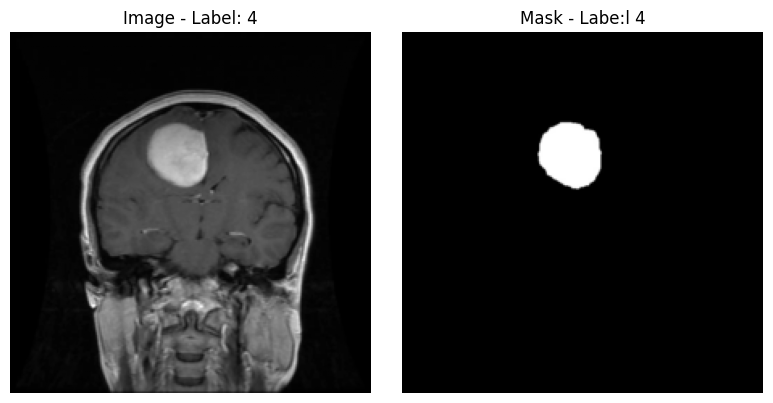

In [24]:
#batch choice
target_batch_idx = 122 

#section in batch
item_idx = 20

#iterating through all batches to chosen one and creating graph and label output
for batch_idx, (images, masks, labels) in enumerate(dl):
    if batch_idx == target_batch_idx:
        img = images[item_idx].squeeze().numpy()
        mask = masks[item_idx].squeeze().numpy()
        label = labels[item_idx].item()

        plt.figure(figsize=(8, 4))

        # Plot image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Image - Label: {label}')
        plt.axis('off')

        # Plot mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask - Labe:l {label}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        break  # stop after first batch


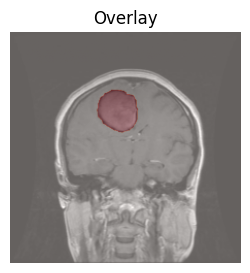

In [25]:
# more plotting stuff to confrim img line up
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img, cmap="gray")
ax.imshow(mask, cmap="Reds", alpha=0.4)  # overlay mask in red
ax.set_title("Overlay")
ax.axis("off")
plt.show()

In [26]:
from ultralytics import YOLO
from roboflow import Roboflow

In [27]:
#Get API key and check workspace env
get_key = os.environ.get("ROBO_FLOW_KEY")
rf = Roboflow(api_key=get_key)
print(rf.workspace())

loading Roboflow workspace...
{
  "name": "NeuroModel",
  "url": "neuromodel",
  "projects": [
    "neuromodel/yourbrain-q5u3r"
  ]
}


In [28]:
#uploading images to my project workspace inside of Roboflow
workspaceID = 'neuromodel'
projectID = 'yourbrain-q5u3r'
project = rf.workspace(workspaceID).project(projectID)

loading Roboflow workspace...
loading Roboflow project...
